# assignment_1_09_file_3

<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: 9 </center></h4>
<h4><center> Group Member 1: Lee Wei Qing, A0205666B </center></h4>
<h4><center> Group Member 2: Madeline Lim Chia Bing, A0205053W </center></h4>
<h4><center> Group Member 3: Mabel Lee Wei Ling, A0204397B </center></h4>
<h4><center> Group Member 4: Wu Wei Ye, A0200578H </center></h4>




## **Contents**
## Reduced dataset (training with first 200 images and test on last 5000 images)
### 1.  Logistic Regression Model with Different optimisation methods
> #### 1.1 Naive Gradient Descent (automatic learning rate)
> #### 1.2 Stochastic Gradient Descent
> #### 1.3 Stochastic Gradient Descent with Momentum

### 2. Regularisation on Stochastic Gradient Descent with Momentum
> #### 2.1 Lasso Regularisation
> #### 2.2 Ridge Regularisation

### 3. Training with Preprocessed Images on model with SGDM with regularisation
> #### 3.1 Black and White Images
> #### 3.2 Blurred Images
> #### 3.3 Sharpened Images
> #### 3.4 Higher Contrast Images
> #### 3.5 Lower Contrast Images

### 4. Ensemble of Models

In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

In [ ]:
# file paths
path = "./img_celeba_small/"
path_csv = "celeba.csv"

In [ ]:
attribute = pd.read_csv(path_csv))

In [ ]:
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f))
                 and f.endswith(".jpg")]
                 
# sort the images by alphabetical order 
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


In [ ]:
# reading in N_to_load numbers of images and converting to array
df = []

N_to_load = 200
start = time.time()
for k, file in enumerate(all_img[:N_to_load]):
    im = imageio.imread(os.path.join(path, file)).astype(float)
    im = resize(im, (100,100) )

    df.append(im)

    n_files_loaded_so_far = k+1
    if n_files_loaded_so_far % 100 == 0:
      speed = n_files_loaded_so_far / (time.time() - start )
      print(f"Files loaded: {n_files_loaded_so_far} \t Loading Speed: {speed:2.1f} files loaded per second")

# reading in test data set
df_test = []
start = time.time()
for k, file in enumerate(all_img[15000:]):
    im = imageio.imread(os.path.join(path, file)).astype(float)
    im = resize(im, (100,100) )

    df_test.append(im)

    n_files_loaded_so_far = k+1
    if n_files_loaded_so_far % 100 == 0:
      speed = n_files_loaded_so_far / (time.time() - start )
      print(f"Files loaded: {n_files_loaded_so_far} \t Loading Speed: {speed:2.1f} files loaded per second")

Files loaded: 100 	 Loading Speed: 18.6 files loaded per second
Files loaded: 200 	 Loading Speed: 16.9 files loaded per second
Files loaded: 100 	 Loading Speed: 1.6 files loaded per second
Files loaded: 200 	 Loading Speed: 3.0 files loaded per second
Files loaded: 300 	 Loading Speed: 4.3 files loaded per second
Files loaded: 400 	 Loading Speed: 5.6 files loaded per second
Files loaded: 500 	 Loading Speed: 6.7 files loaded per second
Files loaded: 600 	 Loading Speed: 7.7 files loaded per second
Files loaded: 700 	 Loading Speed: 8.7 files loaded per second
Files loaded: 800 	 Loading Speed: 9.6 files loaded per second
Files loaded: 900 	 Loading Speed: 10.5 files loaded per second
Files loaded: 1000 	 Loading Speed: 11.3 files loaded per second
Files loaded: 1100 	 Loading Speed: 12.1 files loaded per second
Files loaded: 1200 	 Loading Speed: 12.8 files loaded per second
Files loaded: 1300 	 Loading Speed: 13.6 files loaded per second
Files loaded: 1400 	 Loading Speed: 14.3 fil

In [ ]:
len(df_test)

5000

# 1.  Logistic Regression Model with Different optimisation methods
> #### 1.1 Naive Gradient Descent (automatic learning rate)
> #### 1.2 Stochastic Gradient Descent
> #### 1.3 Stochastic Gradient Descent with Momentum


## 1.1 Naive Gradient Descent (automatic learning rate)

In [ ]:
# functions required
def prediction(beta, x):
    """
    desc:
    =====
    compute the probability that x is associated to a +1 label

    args:
    ====
     x: vector of dimension 784
     beta: vector of dimension 784 (logistic reg param)     
    """
    proba = 1. / (1. + np.exp(-np.dot(x,beta)))
    return proba

# let us now define a function tat can compute the error rate
@jax.jit
def compute_error_rate(beta, X, Y):
    # let us parallelize the function:
    prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
    
    # compute predictions
    pred_bool = prediction_batch(beta, X) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1
    
    # return the error rate
    return np.mean(Y == pred)

    
@jax.jit
def loss_single(beta, x, y):
    """
    desc:
    =====
    compute the loss for a single image

    args:
    ====
     beta: vector of dimension 784 (logistic reg param)
     x: vector of dimension 784
     y: {+1, -1} label
    """
    return np.log(1. + np.exp(-y * np.dot(x,beta)))

@jax.jit
def loss(beta, X, Y):
    """
    desc:
    ====
     logistic regression loss
    """ 

    # loss_single(beta, x, y)
    loss_all = jax.vmap(loss_single, in_axes=(None, 0, 0))
    
    # compute all the individual losses
    loss_individuals = loss_all(beta, X_train, y_train)
    
    # return the average loss
    return np.mean(loss_individuals)

# let us compute the gradient and compile
loss_value_and_grad = jax.jit(jax.value_and_grad(loss))

In [ ]:
def GD(beta, X_train, y_train, n_iter, learning_rate_init, alpha):
    start_time = time.time()
    loss_history = []
    history_learning_rate = []
    first_iter = True

    for k in range(n_iter):
        v,g = loss_value_and_grad(beta, X_train, y_train)
        if first_iter:
            learning_rate = learning_rate_init
            first_iter = False
        else:
            learning_rate = history_learning_rate[-1]

        while loss(beta - learning_rate * g, X_train, y_train) > v + alpha * learning_rate * np.dot(g, -g):
            learning_rate = alpha * learning_rate

        beta = beta - learning_rate * g
        history_learning_rate.append(learning_rate)
        loss_history.append(v)
        
        if k % 300 == 0:
            err_train = 100*compute_error_rate(beta, X_train, y_train)
            err_val= 100*compute_error_rate(beta, X_test, y_test)        
            print(f"iter:{k} \t Loss:{v:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run.")
    return loss_history, beta

In [ ]:
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta = onp.copy(beta_init)
n_iter = 2000
learning_rate_init = 1.
alpha = 0.5

X_train = onp.array(df[:200]).reshape(200, 100*100*3)
X_test = onp.array(df_test[:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

loss_history_1, beta_1 = GD(beta, X_train, y_train, n_iter, learning_rate_init, alpha)

iter:0 	 Loss:135.987 	 error(train):51.5% 	 error(val):52.3%
iter:300 	 Loss:9.131 	 error(train):66.0% 	 error(val):59.5%
iter:600 	 Loss:5.798 	 error(train):73.5% 	 error(val):61.8%
iter:900 	 Loss:3.907 	 error(train):79.0% 	 error(val):63.7%
iter:1200 	 Loss:2.369 	 error(train):81.5% 	 error(val):65.0%
iter:1500 	 Loss:1.467 	 error(train):86.5% 	 error(val):65.8%
iter:1800 	 Loss:1.076 	 error(train):89.5% 	 error(val):66.1%
Took 64.91178727149963 s to run.


In [ ]:
compute_error_rate(beta_1, X_train, y_train)

DeviceArray(0.91, dtype=float64)

In [ ]:
compute_error_rate(beta_1, X_test, y_test)

DeviceArray(0.6616, dtype=float64)

Text(0.5, 0, 'iter')

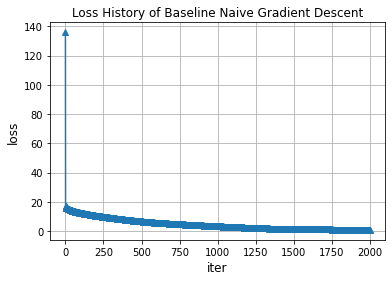

In [ ]:
plt.plot(loss_history_1, "-^")
#plt.yscale("log")
plt.grid(True)
plt.title("Loss History of Baseline Naive Gradient Descent")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("iter", fontsize = 12)

In [ ]:
from sklearn.metrics import roc_auc_score
def AUC(beta, X_test, y_test):
    prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
    pred_bool = prediction_batch(beta, X_test) > 0.5
    pred = 2*pred_bool - 1
    return(roc_auc_score(y_test, pred))

In [ ]:
AUC(beta_1, X_test, y_test)

0.6535197815016393

## 1.2 Stochastic Gradient Descent 

In [ ]:
def SGD(b, X, Y, n, m, lr):
    start_time = time.time()
    N = len(X_train)
    img_indices = onp.arange(N)

    loss_history = []
    loss_history_end_epoch = []
    for epoch in range(n):
        n_minibatch = N // m + 1
        onp.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            batch_indices = onp.arange(k*m, (k+1)*m) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X[batch_indices]
            y_minibatch = Y[batch_indices]

            val, grad = loss_value_and_grad(b, X_minibatch, y_minibatch)
            b = b - lr * grad

            loss_history.append(val)
            all_loss_within_epoch.append(val)
        loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
        err_train = 100*compute_error_rate(b, X, Y)
        err_val= 100*compute_error_rate(b, X_test, y_test)        
        print(f"epoch:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run.")
    return loss_history_end_epoch, b

In [ ]:
n_epoch = 50
minibatch_size = 50

onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta = onp.copy(beta_init)
learning_rate = 0.000001

X_train = onp.array(df[:200]).reshape(200, 100*100*3)
X_test = onp.array(df_test[:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

In [ ]:
loss_history_2, beta_2 = SGD(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate)

epoch:0 	 Loss:28.546 	 error(train):53.0% 	 error(val):54.2%
epoch:1 	 Loss:46.030 	 error(train):41.5% 	 error(val):45.1%
epoch:2 	 Loss:33.963 	 error(train):55.5% 	 error(val):57.6%
epoch:3 	 Loss:50.596 	 error(train):49.5% 	 error(val):48.4%
epoch:4 	 Loss:24.698 	 error(train):56.5% 	 error(val):57.6%
epoch:5 	 Loss:42.548 	 error(train):51.5% 	 error(val):49.6%
epoch:6 	 Loss:25.840 	 error(train):57.5% 	 error(val):58.0%
epoch:7 	 Loss:40.390 	 error(train):54.0% 	 error(val):50.5%
epoch:8 	 Loss:26.459 	 error(train):57.5% 	 error(val):58.3%
epoch:9 	 Loss:39.175 	 error(train):55.5% 	 error(val):51.6%
epoch:10 	 Loss:23.745 	 error(train):57.5% 	 error(val):58.5%
epoch:11 	 Loss:35.629 	 error(train):57.5% 	 error(val):52.2%
epoch:12 	 Loss:23.152 	 error(train):57.5% 	 error(val):58.9%
epoch:13 	 Loss:34.629 	 error(train):59.5% 	 error(val):53.3%
epoch:14 	 Loss:21.575 	 error(train):57.5% 	 error(val):59.4%
epoch:15 	 Loss:31.925 	 error(train):60.0% 	 error(val):53.5%
ep

Text(0.5, 0, 'epoch')

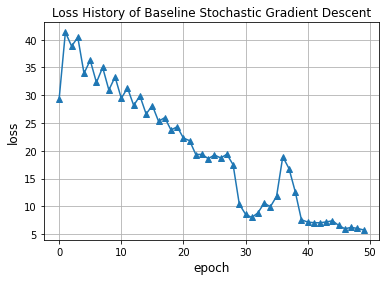

In [ ]:
plt.plot(loss_history_2, "-^")
#plt.yscale("log")
plt.grid(True)
plt.title("Loss History of Baseline Stochastic Gradient Descent")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)

In [ ]:
AUC(beta_2, X_test, y_test)

0.6773152757858629

## 1.3 Stochastic Gradient Descent with Momentum

In [ ]:
def SGD_momentum(X_train, X_test, y_train, y_test, beta_init):
    
    start_time = time.time()
    n_epoch = 10
    minibatch_size = 50 #size of the minibatchs
    N = len(X_train)
    img_indices = onp.arange(N)

    loss_history3 = []
    loss_history_end_epoch3 = []
    beta = onp.copy(beta_init)
    beta_previous = onp.copy(beta_init)
    learning_rate = 0.000001
    gamma = 0.9

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        onp.random.shuffle(img_indices) # need to keep the batches randomised

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N # to ensure that we stay in the range of N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X_train[batch_indices]
            y_minibatch = y_train[batch_indices]

            # compute the stochastic gradient
            val, grad = loss_value_and_grad(beta, X_minibatch, y_minibatch)

            # do one step of SGD

            temp = beta
            beta = temp - learning_rate * grad + gamma * (temp - beta_previous)
            beta_previous = temp

            # book-keeping
            loss_history3.append(val)
            all_loss_within_epoch.append(val)
        loss_history_end_epoch3.append(onp.mean(all_loss_within_epoch))
        err_train = 100*compute_error_rate(beta, X_train, y_train)
        err_val= 100*compute_error_rate(beta, X_test, y_test)        
        print(f"iter:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run")
    return (loss_history3, loss_history_end_epoch3, beta)

In [ ]:
onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta = onp.copy(beta_init)

X_train = onp.array(df[:200]).reshape(200, 100*100*3)
X_test = onp.array(df_test[:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

loss_history_3, loss_history_end_epoch3, beta_3 = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:21.978 	 error(train):54.0% 	 error(val):49.5%
iter:1 	 Loss:14.354 	 error(train):65.0% 	 error(val):59.0%
iter:2 	 Loss:9.479 	 error(train):69.5% 	 error(val):61.5%
iter:3 	 Loss:5.295 	 error(train):74.5% 	 error(val):63.3%
iter:4 	 Loss:4.129 	 error(train):85.5% 	 error(val):66.5%
iter:5 	 Loss:2.190 	 error(train):89.0% 	 error(val):69.7%
iter:6 	 Loss:1.168 	 error(train):91.0% 	 error(val):71.6%
iter:7 	 Loss:0.362 	 error(train):93.0% 	 error(val):69.9%
iter:8 	 Loss:0.112 	 error(train):86.5% 	 error(val):71.8%
iter:9 	 Loss:0.102 	 error(train):90.5% 	 error(val):68.8%
Took 3.4536051750183105 s to run


Text(0.5, 0, 'epoch')

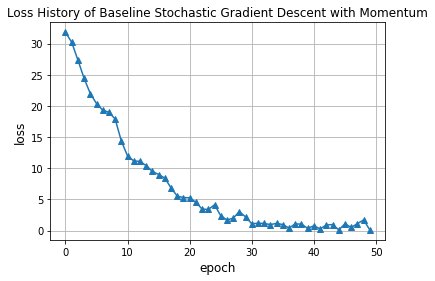

In [ ]:
plt.plot(loss_history_3, "-^")
#plt.yscale("log")
plt.grid(True)
plt.title("Loss History of Baseline Stochastic Gradient Descent with Momentum")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)

In [ ]:
AUC(beta_3, X_test, y_test)

0.6992943571067393

# 2. Regularisation on Stochastic Gradient Descent with Momentum
> #### 2.1 Lasso Regularisation
> #### 2.2 Ridge Regularisation


In [ ]:
@jax.jit
def loss_ridge(beta, X, Y, ridge_lambda):
    """
    desc:
    ====
     logistic regression loss
    """ 

    # loss_single(beta, x, y)
    loss_all = jax.vmap(loss_single, in_axes=(None, 0, 0))
    
    # compute all the individual losses
    loss_individuals = loss_all(beta, X_train, y_train)
    
    # return the average loss
    return np.mean(loss_individuals) + ridge_lambda*(np.linalg.norm(beta, ord = 2))

@jax.jit
def loss_lasso(beta, X, Y, lasso_lambda):
    """
    desc:
    ====
     logistic regression loss
    """ 

    # loss_single(beta, x, y)
    loss_all = jax.vmap(loss_single, in_axes=(None, 0, 0))
    
    # compute all the individual losses
    loss_individuals = loss_all(beta, X_train, y_train)
    
    # return the average loss
    return np.mean(loss_individuals) + lasso_lambda*(np.linalg.norm(beta, ord = 1))

# let us compute the gradient and compile
loss_value_and_grad_lasso = jax.jit(jax.value_and_grad(loss_lasso))
# let us compute the gradient and compile
loss_value_and_grad_ridge = jax.jit(jax.value_and_grad(loss_ridge))

## 2.1 Lasso Regularisation

In [ ]:
# using loss_value_and_grad_lasso 
def SGDM_lasso(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma, lasso_lambda):
    start_time = time.time()
    N = len(X_train)
    img_indices = onp.arange(N)

    beta_previous = onp.copy(beta)
    loss_history = []
    loss_history_end_epoch = []
    for epoch in range(n_epoch):
        n_minibatch = N // minibatch_size + 1
        onp.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X_train[batch_indices]
            y_minibatch = y_train[batch_indices]

            val, grad = loss_value_and_grad_lasso(beta, X_minibatch, y_minibatch, lasso_lambda)
            
            temp = beta
            beta = temp - learning_rate * grad + gamma * (temp - beta_previous)
            beta_previous = temp

            loss_history.append(val)
            all_loss_within_epoch.append(val)
        loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
        err_train = 100*compute_error_rate(beta, X_train, y_train)
        err_val= 100*compute_error_rate(beta, X_test, y_test)        
        print(f"epoch:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run.")
    return loss_history_end_epoch, beta

In [ ]:
n_epoch = 10
minibatch_size = 50

onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta = onp.copy(beta_init)
learning_rate = 0.000001
gamma = 0.9

X_train = onp.array(df[:200]).reshape(200, 100*100*3)
X_test = onp.array(df_test[:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

In [ ]:
loss_history_3, beta_3 = SGDM_lasso(beta, X_train, y_train, 10, minibatch_size, learning_rate, gamma, 0.4)

epoch:0 	 Loss:77.155 	 error(train):54.0% 	 error(val):49.5%
epoch:1 	 Loss:69.375 	 error(train):65.0% 	 error(val):58.9%
epoch:2 	 Loss:64.330 	 error(train):70.5% 	 error(val):61.6%
epoch:3 	 Loss:59.820 	 error(train):78.5% 	 error(val):66.6%
epoch:4 	 Loss:56.515 	 error(train):85.0% 	 error(val):68.5%
epoch:5 	 Loss:55.768 	 error(train):89.5% 	 error(val):69.6%
epoch:6 	 Loss:55.344 	 error(train):91.5% 	 error(val):69.2%
epoch:7 	 Loss:54.161 	 error(train):93.5% 	 error(val):72.0%
epoch:8 	 Loss:53.835 	 error(train):96.0% 	 error(val):70.8%
epoch:9 	 Loss:53.491 	 error(train):99.0% 	 error(val):71.9%
Took 6.211667776107788 s to run.


Text(0.5, 0, 'epoch')

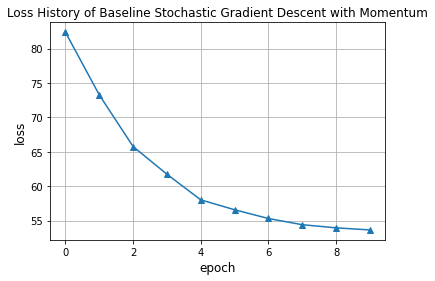

In [ ]:
plt.plot(loss_history_3, "-^")
#plt.yscale("log")
plt.grid(True)
plt.title("Loss History of Baseline Stochastic Gradient Descent with Momentum")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)

In [ ]:
AUC(beta_3, X_test, y_test)

0.7097432683674815

## 2.2 Ridge regularisation

In [ ]:
# using loss_value_and_grad_ridge 
def SGDM_ridge(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma, ridge_lambda):
    start_time = time.time()
    N = len(X_train)
    img_indices = onp.arange(N)

    beta_previous = onp.copy(beta)
    loss_history = []
    loss_history_end_epoch = []
    for epoch in range(n_epoch):
        n_minibatch = N // minibatch_size + 1
        onp.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X_train[batch_indices]
            y_minibatch = y_train[batch_indices]

            val, grad = loss_value_and_grad_ridge(beta, X_minibatch, y_minibatch, ridge_lambda)
            
            temp = beta
            beta = temp - learning_rate * grad + gamma * (temp - beta_previous)
            beta_previous = temp

            loss_history.append(val)
            all_loss_within_epoch.append(val)
        loss_history_end_epoch.append(onp.mean(all_loss_within_epoch))
        err_train = 100*compute_error_rate(beta, X_train, y_train)
        err_val= 100*compute_error_rate(beta, X_test, y_test)        
        print(f"epoch:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run.")
    return loss_history_end_epoch, beta

In [ ]:
loss_history_3, beta_3 = SGDM_ridge(beta, X_train, y_train, 10, minibatch_size, learning_rate, gamma, 0.5)

epoch:0 	 Loss:22.476 	 error(train):54.0% 	 error(val):49.5%
epoch:1 	 Loss:14.852 	 error(train):65.0% 	 error(val):59.0%
epoch:2 	 Loss:9.977 	 error(train):69.5% 	 error(val):61.5%
epoch:3 	 Loss:5.796 	 error(train):74.5% 	 error(val):63.3%
epoch:4 	 Loss:4.618 	 error(train):85.5% 	 error(val):66.5%
epoch:5 	 Loss:2.742 	 error(train):89.0% 	 error(val):69.5%
epoch:6 	 Loss:1.709 	 error(train):90.0% 	 error(val):71.7%
epoch:7 	 Loss:0.875 	 error(train):92.5% 	 error(val):70.0%
epoch:8 	 Loss:0.823 	 error(train):98.0% 	 error(val):72.4%
epoch:9 	 Loss:0.607 	 error(train):90.0% 	 error(val):72.1%
Took 6.884832143783569 s to run.


Text(0.5, 0, 'epoch')

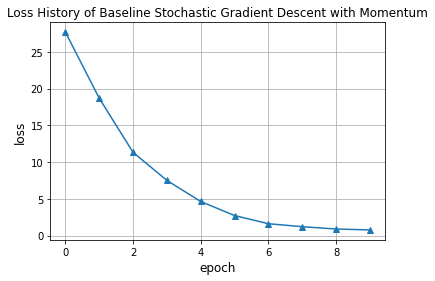

In [ ]:
plt.plot(loss_history_3, "-^")
#plt.yscale("log")
plt.grid(True)
plt.title("Loss History of Baseline Stochastic Gradient Descent with Momentum")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)

In [ ]:
AUC(beta_3, X_test, y_test)

0.6898763696177445

# 3. Training with Preprocessed Images on model with SGDM with regularisation
> #### 3.1 Black and White Images
> #### 3.2 Blurred Images
> #### 3.3 Sharpened Images
> #### 3.4 Higher Contrast Images
> #### 3.5 Lower Contrast Images


In [ ]:
from PIL import Image, ImageEnhance
import cv2
import skimage.io
import skimage.filters

In [ ]:
def black_and_white(im):
    '''
    inputs: array of original image
    =========
    output: array of b&w image
    '''
    #load image
    # im = imageio.imread(os.path.join(path, im_path)).astype(float)
    #transform to black and white by averaging the 3 color channels
    im_output = np.mean(im, axis=2)
    return(im_output)

from functools import partial
#@partial(jax.jit, static_argnums=(1,))
def sharpened(im):
    '''
    inputs:  array of original image
    =========
    output: array of sharpened image
    '''
    # Defining the kernel of size 3x3
    # im = imageio.imread(os.path.join(path, im_path))
    kernel = onp.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ])
    im_output = cv2.filter2D(im, -1, kernel)
    return(np.asarray(im_output))

def blurred(im, sigma):
    '''
    inputs:  im: array of original image
             sigma: to be used in x and y direction, 
                    (2*sigma*truncate) gives resulting kernel size
    =========
    output: array of blurred image
    '''
    # im = imageio.imread(os.path.join(path, im_path)).astype(float)
    blurred = skimage.filters.gaussian(
          im, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
    return blurred

def change_contrast(im, factor):
    '''
    inputs:  im: a single image sub path,
            factor: number to control contrast, 1 gives original image,
                        < 1 decreases contrast and > 1 increases contrast
    =========
    output: array of new image
    '''
    # image brightness enhancer
    
    im = Image.fromarray(im.astype('uint8'))
    enhancer = ImageEnhance.Contrast(im)
    im_enhanced = enhancer.enhance(factor)
    im_output = np.asarray(im_enhanced)
    return(im_output)

In [ ]:
# preprocess all train images in the train dataset into blurred, sharpened, higher and lower contrast
# these functions cannot be run using vmap due to conversion errors
res_blur = [i for i in range(200)]
res_blur1 = [i for i in range(5000)]

res_sharp = [i for i in range(200)]
res_sharp1 = [i for i in range(5000)]

res_highcontrast = [i for i in range(200)]
res_highcontrast1 = [i for i in range(5000)]

res_lowcontrast = [i for i in range(200)]
res_lowcontrast1 = [i for i in range(5000)]

for i in range(200):
    res_blur[i] = blurred(df[i], 2)
    res_sharp[i] = sharpened(df[i])
    res_highcontrast[i] = change_contrast(df[i], 1.5)
    res_lowcontrast[i] = change_contrast(df[i], 0.5)

for i in range(5000):
    res_blur1[i] = blurred(df_test[i], 2)
    res_sharp1[i] = sharpened(df_test[i])
    res_highcontrast1[i] = change_contrast(df_test[i], 1.5)
    res_lowcontrast1[i] = change_contrast(df_test[i], 0.5)

In [ ]:
# preprocess train and test images in the train dataset into blurred, sharpened, higher and lower contrast
df = np.asarray(df)
# using vmap to preprocess the images
bnw_vmapped = jax.jit(jax.vmap(black_and_white))
res_bw = bnw_vmapped(df)

df1_test = np.asarray(df_test)
# using vmap to preprocess the images
bnw_vmapped = jax.jit(jax.vmap(black_and_white))
res_bw1 = bnw_vmapped(df1_test)

## 3.1 Black and White Images

In [ ]:
X_train = onp.array(res_bw[:200]).reshape(200, 100*100)
X_test = onp.array(res_bw1[:]).reshape(5000, 100*100)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

n_epoch = 10
minibatch_size = 5
onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100),size=(100*100))
beta = onp.copy(beta_init)
learning_rate = 0.000001
gamma = 0.9

# fitting and testing model
# bnw_SGDM_loss_history = SGDM(X_train, X_test, y_train, y_test, beta_init)
loss_history_bnw, beta_bnw = SGDM_lasso(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma, 0.4)

epoch:0 	 Loss:35.042 	 error(train):81.0% 	 error(val):64.5%
epoch:1 	 Loss:31.350 	 error(train):90.0% 	 error(val):66.8%
epoch:2 	 Loss:30.112 	 error(train):99.0% 	 error(val):66.7%
epoch:3 	 Loss:29.385 	 error(train):99.5% 	 error(val):66.9%
epoch:4 	 Loss:28.724 	 error(train):99.5% 	 error(val):66.9%
epoch:5 	 Loss:28.082 	 error(train):99.5% 	 error(val):66.9%
epoch:6 	 Loss:27.468 	 error(train):100.0% 	 error(val):66.8%
epoch:7 	 Loss:26.870 	 error(train):100.0% 	 error(val):66.8%
epoch:8 	 Loss:26.282 	 error(train):100.0% 	 error(val):66.7%
epoch:9 	 Loss:25.702 	 error(train):100.0% 	 error(val):66.7%
Took 3.082864999771118 s to run.


In [ ]:
AUC(beta_bnw, X_test, y_test)

0.6467959907370411

## 3.2 Blurred Images

In [ ]:
X_train = onp.array(res_blur[:200]).reshape(200, 100*100*3)
X_test = onp.array(res_blur1[:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

n_epoch = 10
minibatch_size = 5
onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta = onp.copy(beta_init)
learning_rate = 0.000001
gamma = 0.9

# fitting and testing model
loss_history_3, beta_3 = SGDM_lasso(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma, 0.4)

epoch:0 	 Loss:55.334 	 error(train):86.0% 	 error(val):73.7%
epoch:1 	 Loss:52.138 	 error(train):97.0% 	 error(val):74.6%
epoch:2 	 Loss:50.013 	 error(train):100.0% 	 error(val):75.2%
epoch:3 	 Loss:48.177 	 error(train):100.0% 	 error(val):75.6%
epoch:4 	 Loss:46.391 	 error(train):100.0% 	 error(val):75.3%
epoch:5 	 Loss:44.651 	 error(train):100.0% 	 error(val):75.3%
epoch:6 	 Loss:42.957 	 error(train):100.0% 	 error(val):75.3%
epoch:7 	 Loss:41.307 	 error(train):100.0% 	 error(val):75.2%
epoch:8 	 Loss:39.698 	 error(train):100.0% 	 error(val):75.2%
epoch:9 	 Loss:38.132 	 error(train):100.0% 	 error(val):75.1%
Took 15.18274188041687 s to run.


In [ ]:
AUC(beta_3, X_test, y_test)

0.7347362107889723

## 3.3 Sharpened Images

In [ ]:
X_train = onp.array(res_sharp[:200]).reshape(200, 100*100*3)
X_test = onp.array(res_sharp1[:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

n_epoch = 10
minibatch_size = 5
onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta = onp.copy(beta_init)
learning_rate = 0.000001
gamma = 0.9

# # fitting and testing model
loss_history_sharp, beta_sharp = SGDM_lasso(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma, 0.4)

epoch:0 	 Loss:55.334 	 error(train):78.0% 	 error(val):67.3%
epoch:1 	 Loss:52.138 	 error(train):82.5% 	 error(val):68.1%
epoch:2 	 Loss:50.013 	 error(train):84.5% 	 error(val):68.0%
epoch:3 	 Loss:48.177 	 error(train):83.0% 	 error(val):67.9%
epoch:4 	 Loss:46.391 	 error(train):83.0% 	 error(val):68.0%
epoch:5 	 Loss:44.651 	 error(train):84.0% 	 error(val):67.8%
epoch:6 	 Loss:42.957 	 error(train):84.0% 	 error(val):67.8%
epoch:7 	 Loss:41.307 	 error(train):83.5% 	 error(val):67.6%
epoch:8 	 Loss:39.698 	 error(train):82.5% 	 error(val):67.6%
epoch:9 	 Loss:38.132 	 error(train):82.5% 	 error(val):67.2%
Took 7.297983884811401 s to run.


In [ ]:
AUC(beta_sharp, X_test, y_test)

0.6603903074936457

## 3.4 High Contrast Images

In [ ]:
X_train = onp.array(res_highcontrast[:200]).reshape(200, 100*100*3)
X_test = onp.array(res_highcontrast1[:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
n_epoch = 10
minibatch_size = 5
onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta = onp.copy(beta_init)
learning_rate = 0.000001
gamma = 0.9

# # fitting and testing model
# HC_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)
loss_history_hc, beta_hc = SGDM_lasso(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma, 0.4)

epoch:0 	 Loss:53.949 	 error(train):99.0% 	 error(val):72.6%
epoch:1 	 Loss:51.905 	 error(train):100.0% 	 error(val):73.1%
epoch:2 	 Loss:50.022 	 error(train):100.0% 	 error(val):73.3%
epoch:3 	 Loss:48.190 	 error(train):100.0% 	 error(val):73.1%
epoch:4 	 Loss:46.405 	 error(train):100.0% 	 error(val):73.2%
epoch:5 	 Loss:44.667 	 error(train):100.0% 	 error(val):73.1%
epoch:6 	 Loss:42.972 	 error(train):100.0% 	 error(val):72.8%
epoch:7 	 Loss:41.320 	 error(train):100.0% 	 error(val):72.8%
epoch:8 	 Loss:39.710 	 error(train):100.0% 	 error(val):72.9%
epoch:9 	 Loss:38.143 	 error(train):100.0% 	 error(val):73.0%
Took 14.860622882843018 s to run.


In [ ]:
AUC(beta_hc, X_test, y_test)

0.712844661506382

## 3.5 Low Contrast Images

In [ ]:
X_train = onp.array(res_lowcontrast[:200]).reshape(200, 100*100*3)
X_test = onp.array(res_lowcontrast1[:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:199, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
n_epoch = 10
minibatch_size = 5
onp.random.seed(30)
beta_init = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta = onp.copy(beta_init)
learning_rate = 0.000001
gamma = 0.9

# fitting and testing model
# LC_SGDM_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)
loss_history_lc, beta_lc = SGDM_lasso(beta, X_train, y_train, n_epoch, minibatch_size, learning_rate, gamma, 0.4)

epoch:0 	 Loss:53.949 	 error(train):84.0% 	 error(val):65.4%
epoch:1 	 Loss:51.905 	 error(train):84.0% 	 error(val):66.6%
epoch:2 	 Loss:50.022 	 error(train):83.5% 	 error(val):65.8%
epoch:3 	 Loss:48.190 	 error(train):83.5% 	 error(val):65.5%
epoch:4 	 Loss:46.405 	 error(train):83.5% 	 error(val):65.5%
epoch:5 	 Loss:44.667 	 error(train):83.0% 	 error(val):65.4%
epoch:6 	 Loss:42.972 	 error(train):83.0% 	 error(val):65.6%
epoch:7 	 Loss:41.320 	 error(train):83.0% 	 error(val):65.8%
epoch:8 	 Loss:39.710 	 error(train):83.5% 	 error(val):66.0%
epoch:9 	 Loss:38.143 	 error(train):82.5% 	 error(val):66.1%
Took 9.952470541000366 s to run.


In [ ]:
AUC(beta_lc, X_test, y_test)

0.6817656148206028

# 4. Ensemble of Models

In [ ]:
# get individual test data predicted probabilities for each model
prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
X_test_bw = onp.array(res_bw1[:]).reshape(5000, 100*100)
X_test_blur = onp.array(res_blur1[:]).reshape(5000, 100*100*3)
X_test_sharp = onp.array(res_sharp1[:]).reshape(5000, 100*100*3)
X_test_highcon = onp.array(res_highcontrast1[:]).reshape(5000, 100*100*3)
X_test_lowcon = onp.array(res_lowcontrast1[:]).reshape(5000, 100*100*3)

BW_SGD_testpred = prediction_batch(beta_bnw, X_test_bw) > 0.5
blur_SGD_testpred = prediction_batch(beta_3, X_test_blur) > 0.5
sharp_SGD_testpred = prediction_batch(beta_sharp, X_test_sharp) > 0.5
HC_SGD_testpred = prediction_batch(beta_hc, X_test_highcon) > 0.5
LC_SGD_testpred = prediction_batch(beta_lc, X_test_lowcon) > 0.5

In [ ]:
# get individual test data predicted probabilities for each model
prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
X_train_bw = onp.array(res_bw[:200]).reshape(200, 100*100)
X_train_blur = onp.array(res_blur[:200]).reshape(200, 100*100*3)
X_train_sharp = onp.array(res_sharp[:200]).reshape(200, 100*100*3)
X_train_highcon = onp.array(res_highcontrast[:200]).reshape(200, 100*100*3)
X_train_lowcon = onp.array(res_lowcontrast[:200]).reshape(200, 100*100*3)

BW_SGD_trainpred = prediction_batch(beta_bnw, X_train_bw) > 0.5
blur_SGD_trainpred = prediction_batch(beta_3, X_train_blur) > 0.5
sharp_SGD_trainpred = prediction_batch(beta_sharp, X_train_sharp) > 0.5
HC_SGD_trainpred = prediction_batch(beta_hc, X_train_highcon) > 0.5
LC_SGD_trainpred = prediction_batch(beta_lc, X_train_lowcon) > 0.5

In [ ]:
# converting boolean data to 1 and -1
def convert(arr):
    new = []
    for i in range(len(arr)):
        new.append(1 if arr[i] else -1)
    return np.array(new)

In [ ]:
bw_test = convert(BW_SGD_testpred)
blur_test = convert(blur_SGD_testpred)
sharp_test = convert(sharp_SGD_testpred)
hc_test = convert(HC_SGD_testpred)
lc_test = convert(LC_SGD_testpred)

bw_train = convert(BW_SGD_trainpred)
blur_train = convert(blur_SGD_trainpred)
sharp_train = convert(sharp_SGD_trainpred)
hc_train = convert(HC_SGD_trainpred)
lc_train = convert(LC_SGD_trainpred)

In [ ]:
train = np.array([bw_train, blur_train, sharp_train, hc_train, lc_train]) 
test  = np.array([bw_test, blur_test, sharp_test, hc_test, lc_test]) 
names = ['bw','blur','sharp','hc','lc']

In [ ]:
# 3 ways
import itertools
three = list(itertools.combinations(range(1, 6), r=3)) #give tuples

for tup in three:
  a = tup[0]
  b = tup[1]
  c = tup[2]

  proba_test = (test[a-1] + test[b-1]+ test[c-1])
  bool_test = proba_test > 0
  predict_test = 2 * bool_test - 1

  proba_train = (train[a-1] + train[b-1]+train[c-1])
  bool_train = proba_train > 0
  predict_train = 2 * bool_train - 1

  print('Train accuracy for {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], np.mean(y_train == predict_train)))
  print('Test accuracy for {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], np.mean(y_test == predict_test)))
  print('Test AUC for {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], roc_auc_score(y_test, predict_test)))


Train accuracy for bw + blur + sharp is 1.0
Test accuracy for bw + blur + sharp is 0.7338
Test AUC for bw + blur + sharp is 0.716266540147563
Train accuracy for bw + blur + hc is 1.0
Test accuracy for bw + blur + hc is 0.7472000000000001
Test AUC for bw + blur + hc is 0.7291972228202758
Train accuracy for bw + blur + lc is 1.0
Test accuracy for bw + blur + lc is 0.7344
Test AUC for bw + blur + lc is 0.7314032601003843
Train accuracy for bw + sharp + hc is 1.0
Test accuracy for bw + sharp + hc is 0.7184
Test AUC for bw + sharp + hc is 0.7012171880078152
Train accuracy for bw + sharp + lc is 0.9500000000000001
Test accuracy for bw + sharp + lc is 0.6972
Test AUC for bw + sharp + lc is 0.6978965542101679
Train accuracy for bw + hc + lc is 1.0
Test accuracy for bw + hc + lc is 0.7204
Test AUC for bw + hc + lc is 0.716967699692521
Train accuracy for blur + sharp + hc is 1.0
Test accuracy for blur + sharp + hc is 0.7314
Test AUC for blur + sharp + hc is 0.7147251223026214
Train accuracy for 

In [ ]:
# 4 ways
four = list(itertools.combinations(range(1, 6), r=4)) #give tuples

for tup in four:
  a = tup[0]
  b = tup[1]
  c = tup[2]
  d = tup[3]

  proba_test = (test[a-1] + test[b-1]+ test[c-1]+test[d-1])
  bool_test = proba_test > 0
  predict_test = 2 * bool_test - 1

  proba_train = (train[a-1] + train[b-1]+train[c-1]+train[d-1])
  bool_train = proba_train > 0
  predict_train = 2 * bool_train - 1

  print('Train accuracy for {} + {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], names[d-1], np.mean(y_train == predict_train)))
  print('Test accuracy for {} + {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], names[d-1], np.mean(y_test == predict_test)))
  print('Test AUC for {} + {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], names[d-1], roc_auc_score(y_test, predict_test)))

# There are pairwise models that does better, we might not need whole picture

Train accuracy for bw + blur + sharp + hc is 1.0
Test accuracy for bw + blur + sharp + hc is 0.7318
Test AUC for bw + blur + sharp + hc is 0.7062453534528926
Train accuracy for bw + blur + sharp + lc is 1.0
Test accuracy for bw + blur + sharp + lc is 0.7346
Test AUC for bw + blur + sharp + lc is 0.7162974144875213
Train accuracy for bw + blur + hc + lc is 1.0
Test accuracy for bw + blur + hc + lc is 0.7462000000000001
Test AUC for bw + blur + hc + lc is 0.7279403251560673
Train accuracy for bw + sharp + hc + lc is 1.0
Test accuracy for bw + sharp + hc + lc is 0.7198
Test AUC for bw + sharp + hc + lc is 0.7021602512908511
Train accuracy for blur + sharp + hc + lc is 1.0
Test accuracy for blur + sharp + hc + lc is 0.7318
Test AUC for blur + sharp + hc + lc is 0.7150698310237521


In [ ]:
four = list(itertools.combinations(range(1, 6), r=4)) #give tuples
four

[(1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5)]

In [ ]:
# 5 ways
[a,b,c,d,e] = [1,2,3,4,5]

proba_test = (test[a-1] + test[b-1] + test[c-1] + test[d-1] + test[e-1])
bool_test = proba_test > 0
predict_test = 2 * bool_test - 1

proba_train = (train[a-1] + train[b-1] + train[c-1] + train[d-1] + train[e-1])
bool_train = proba_train > 0
predict_train = 2 * bool_train - 1

print('Train accuracy for {} + {} + {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], names[d-1], names[e-1], np.mean(y_train == predict_train)))
print('Test accuracy for {} + {} + {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], names[d-1], names[e-1], np.mean(y_test == predict_test)))
print('Test AUC for {} + {} + {} + {} + {} is {}'.format(names[a-1],names[b-1], names[c-1], names[d-1], names[e-1], roc_auc_score(y_test, predict_test)))

# There are pairwise models that does better, we might not need whole picture

Train accuracy for bw + blur + sharp + hc + lc is 1.0
Test accuracy for bw + blur + sharp + hc + lc is 0.7344
Test AUC for bw + blur + sharp + hc + lc is 0.7244885575262033
